# Packages

### Downloading packages 
#### Select and run just either one of them

In [2]:
!pip3 install --upgrade pip
!pip3 install pandas
!pip3 install seaborn --force
!pip3 install matplotlib
!pip3 install sklearn
!pip3 install missingno

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Defaulting to user installation because normal site-packages is 

### Importing libraries

In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import scale

### Reading files and setting variables

In [4]:
sns.set_style("white")
path, file, extension = '../../data/', 'Results for 141', '.csv'
df = pd.read_csv (os.path.join(path, file) + extension, sep = ',')

# ETL

### Renaming columns and changing axis order

In [5]:
df.insert(loc = 1, column = 'Overall Score', value = df['Overall'])
df.drop(['Overall'], axis=1, inplace=True)

### Reindexing columns

In [6]:
df = df.reindex(columns=[
    'Employee', 'Overall Score', 'EC2 (2)', 
    'S3 Arch (0.5)', 'S3 Access (0.5)', 'S3 Classes (0.5)', 'S3 DR (0.5)', 'IAM (1)', 'Networking (2)', 'Net. App. Reliability (2)', 
    'Configuration drift', 'Count and ForEach', 'Environment', 'Organizing resources', 'Process', 'Secrets and States', 'Sensitive information', 'TF Best practices', 'Values to terraform', 
    'Architecture: Auto Scaling', 'Architecture: Control Plane', 'Core Concepts', 'Services & Networking: Ingress', 'Services & Networking: Service', 'Workload Management'
])

### Re-group of columns for better management

In [7]:
df.columns = [
    '[Candidate] ID', '[Candidate] Overall',
    '[AWS] EC2', '[AWS] S3: Arch', '[AWS] S3: Access', '[AWS] S3: Classes', '[AWS] S3: DR', '[AWS] IAM', '[AWS] Networking', '[AWS] Net. App. Reliability',
    '[TF] Configuration drifts', '[TF] Use of count & for_each', '[TF] Environments', '[TF] Managing resources', '[TF] Process', '[TF] Secrets and States', '[TF] Sensitive information', '[TF] Best practices', '[TF] Managing values', 
    '[K8] Architecture: Auto Scaling', '[K8] Architecture: Control Plane', '[K8] Core Concepts', '[K8] Services & Networking: Ingress', '[K8] Services & Networking: Service', '[K8] Workload Management'
]

### Adding hired/no hired labels

In [8]:
df['Hired'] = ['Yes' if x >= 50 else 'No' for x in df['[Candidate] Overall']]
df.insert(loc = 1, column = '[Candidate] Hired', value = df['Hired'])
df.drop(['Hired'], axis=1, inplace=True)

# EDA

## Functions definitions

### Disclaimer

In [9]:
'''
Most of these functions have been taken from the 'EDA_Attrition_Dataset.ipynb' file, so all coding credits go to the respective author.
'''

"\nMost of these functions have been taken from the 'EDA_Attrition_Dataset.ipynb' file, so all coding credits go to the respective author.\n"

### Generate pie chart

In [10]:
def generate_pie_chart(df, feature, name):
    # Detecting quantities of each class
    label_yes = sum(df[feature] == "Yes")
    label_no  = sum(df[feature] == "No")

    # Defining labels
    size_of_groups = [label_no, label_yes]
    names          = ["No {}" .format(name), "{}" .format(name)]

    # Generating outer cirle plot
    plt.figure(figsize=(5, 5))
    plt.title("Number of observations per class of the {} variable" .format (name))
    plt.pie(size_of_groups, labels=names)

    # Adding a circle at the center to create the pie
    my_circle = plt.Circle((0,0), 0.7, color='white')
    p         = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

### Generate barplot

In [11]:
def generate_barplot(df, feature, order=None):
    # Replacing missing values with a string
    new_df = df.copy()
    new_df[feature] = df[feature].fillna('Missing')

    # Generating bar-plot chart
    plt.figure(figsize=(6, 5))
    ax = sns.countplot(x=feature, data=new_df, edgecolor='k', order=order)
    plt.title("Number of observations according to feature {0}".format(feature))
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

### Generate boxplots

In [12]:
def generate_boxplots(df, columns = df.columns[0]):
    # Obtaining numerical features
    new_df = df.select_dtypes(include="number")
    # new_df.drop(columns=columns, inplace=True)
    new_df_cols = new_df.columns
    std_cols = []

    # Standardizing features
    for feature in new_df_cols:
        new_df["{0}_scaled".format(feature)] = scale(new_df[feature], with_mean=True, with_std=True)
        std_cols.append("{0}_scaled".format(feature))

    # Generating box-plot of original features
    f, axes = plt.subplots(2, 1, figsize=(15, 10))
    plt.axes(axes[0])
    sns.boxplot(x="variable", y="value", data=pd.melt(new_df[new_df_cols]), orient = 'v', width = 0.5, linewidth = 1.2)
    plt.title("Box plot de features numéricas sin estandarizar")
    plt.xticks([])
    plt.grid()

    # Generando box-plot de las features estandarizadas
    plt.axes(axes[1])
    sns.boxplot(x="variable", y="value", data=pd.melt(new_df[std_cols]), orient = 'v', width = 0.5)
    plt.title("Box plot de features numéricas estandarizadas")
    plt.xticks(rotation=90)
    plt.grid()

### Generate missings

In [13]:
def generate_missings(df):
    msno.matrix(df, figsize=(10, 5), fontsize=12, color=(0.3, 0.5, 0.9))

### Generate correlation analysis

In [14]:
def generate_correlation_analysis (df, columns = df.columns[0]):
   # Excluding ID from the features
   df_copy = df.drop(columns=columns)

   # Generating heat-map with the correlation analysis
   plt.figure(figsize=(7,7))
   sns.heatmap(df_copy.select_dtypes(include="number").corr(), cmap = "viridis") \
      .set_title('Correlation map of numerical features')
   plt.show()

### Generate interactions bewtween columns

In [15]:
# Filtering desired columns
def generate_interactions (df, feature):

    columns = list(df.select_dtypes(include="number").columns) + [feature]

    # Generating pairplot for numerical features
    plt.figure(figsize=(20, 20))
    sns.pairplot(df[columns], hue=feature, palette="husl", corner=True)
    plt.title("Scatter-plot Matrix (pairplot) between features and target")
    plt.legend()
    plt.show()

## Analyzing information

### Sample information

In [16]:
print("\nSample of the dataset with employee information:")
df.head().transpose().to_csv("../../outputs/files/head.csv")
df.head().transpose()


Sample of the dataset with employee information:


,0,1,2,3,4
[Candidate] ID,01b7a5,04bb34,0b2569,0c59a8,0f955f
[Candidate] Hired,Yes,Yes,Yes,Yes,Yes
[Candidate] Overall,64.3444,78.056,69.3444,55.278,83.42
[AWS] EC2,87.5,100.0,87.5,87.5,100.0
[AWS] S3: Arch,100.0,100.0,50.0,0.0,100.0
[AWS] S3: Access,50.0,50.0,50.0,100.0,100.0
[AWS] S3: Classes,50.0,100.0,0.0,100.0,50.0
[AWS] S3: DR,50.0,100.0,50.0,50.0,100.0
[AWS] IAM,0.0,40.0,80.0,40.0,80.0
[AWS] Networking,100.0,100.0,100.0,87.5,100.0


### Counting information

In [17]:
# Obtaining shape of the dataset
print("\nThe dataset has {} rows and {} columns".format(df.shape[0], df.shape[1]))


The dataset has 141 rows and 26 columns


### Information structure

In [18]:
# Getting data type of the columns
print("\nThe structure of the dataset is:")
df.info()


The structure of the dataset is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   [Candidate] ID                       141 non-null    object 
 1   [Candidate] Hired                    141 non-null    object 
 2   [Candidate] Overall                  141 non-null    float64
 3   [AWS] EC2                            141 non-null    float64
 4   [AWS] S3: Arch                       141 non-null    float64
 5   [AWS] S3: Access                     141 non-null    float64
 6   [AWS] S3: Classes                    141 non-null    float64
 7   [AWS] S3: DR                         141 non-null    float64
 8   [AWS] IAM                            141 non-null    float64
 9   [AWS] Networking                     141 non-null    float64
 10  [AWS] Net. App. Reliability          141 non-null    float64
 11

### Calculating descriptive statistics

In [19]:
# Calculating descriptive statistics of the columns
df.describe().transpose().to_csv("../../outputs/files/describe.csv")
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
[Candidate] Overall,141.0,49.123313,22.354227,0.0,31.25,51.667,65.139,90.0
[AWS] EC2,141.0,82.978723,22.720968,0.0,75.00,87.500,100.000,100.0
[AWS] S3: Arch,141.0,67.730496,37.860058,0.0,50.00,100.000,100.000,100.0
[AWS] S3: Access,141.0,52.127660,37.736086,0.0,0.00,50.000,100.000,100.0
[AWS] S3: Classes,141.0,41.489362,38.710209,0.0,0.00,50.000,50.000,100.0
[AWS] S3: DR,141.0,45.035461,36.500961,0.0,0.00,50.000,50.000,100.0
[AWS] IAM,141.0,27.517730,32.648693,0.0,0.00,20.000,60.000,100.0
[AWS] Networking,141.0,71.985816,33.835893,0.0,50.00,87.500,100.000,100.0
[AWS] Net. App. Reliability,141.0,62.677305,37.350470,0.0,37.50,75.000,87.500,100.0
[TF] Configuration drifts,36.0,44.444444,33.333333,0.0,0.00,50.000,50.000,100.0


## Functions executions

### Generate pie chart

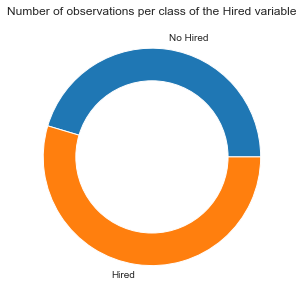

In [20]:
generate_pie_chart (df, df.columns[1], 'Hired')

### Generate barplot

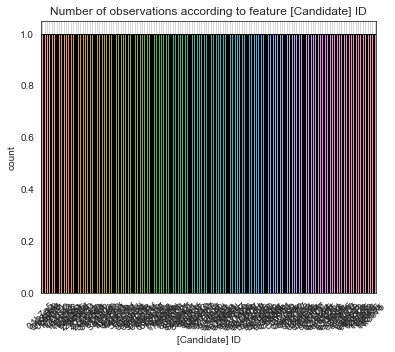

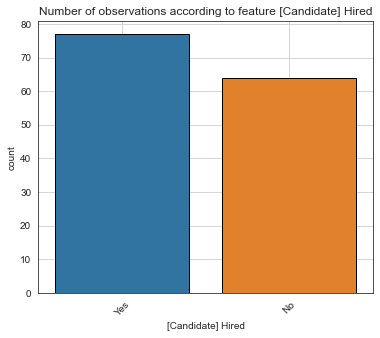

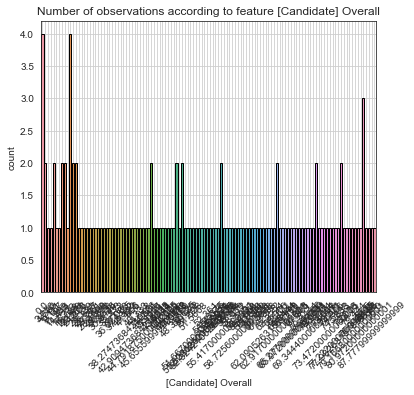

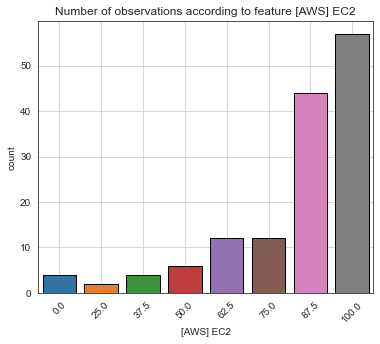

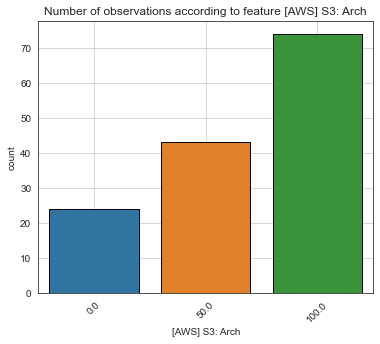

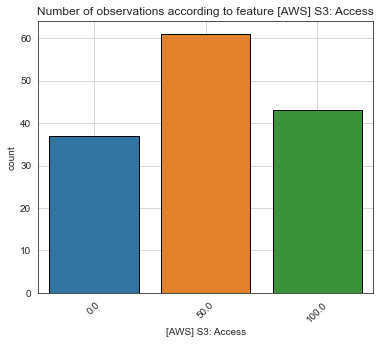

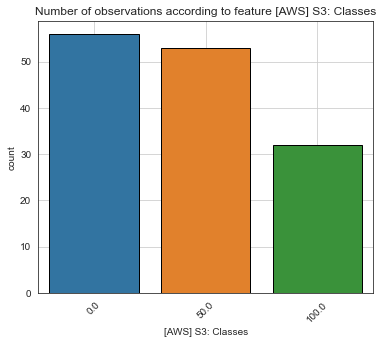

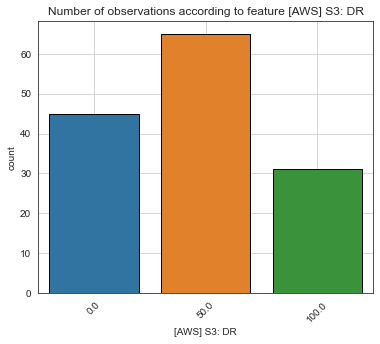

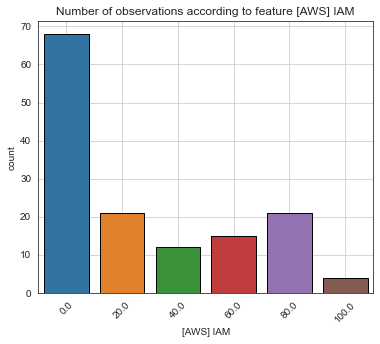

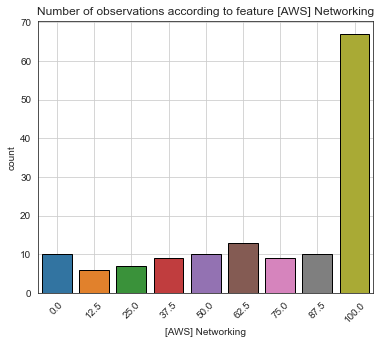

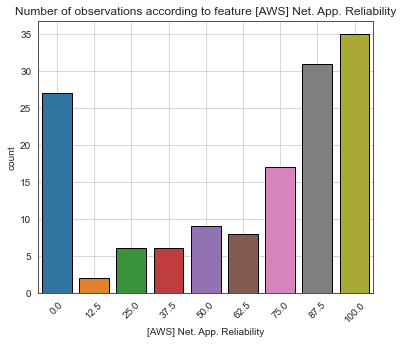

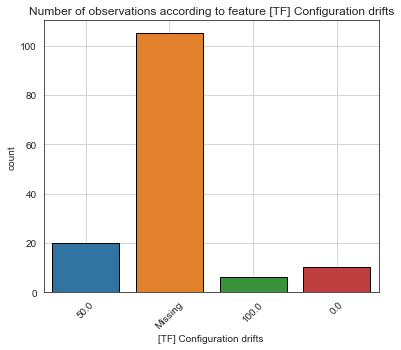

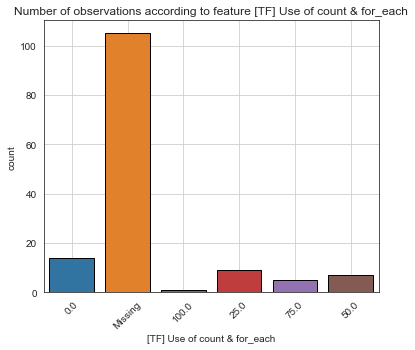

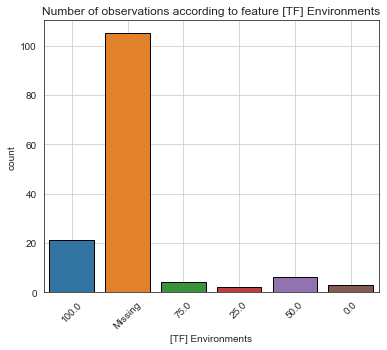

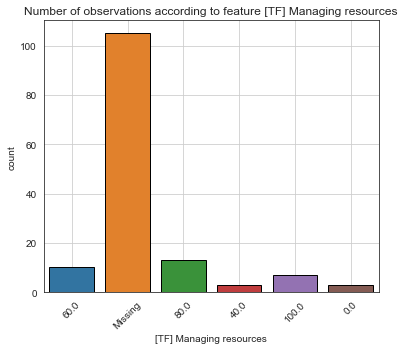

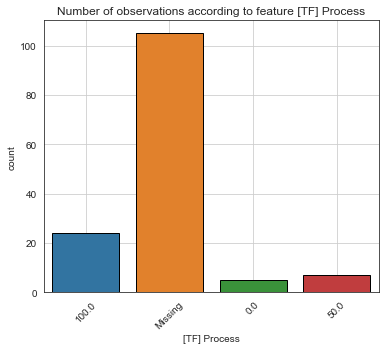

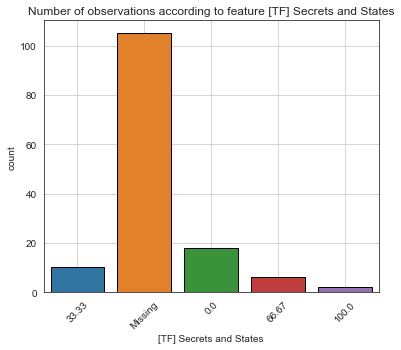

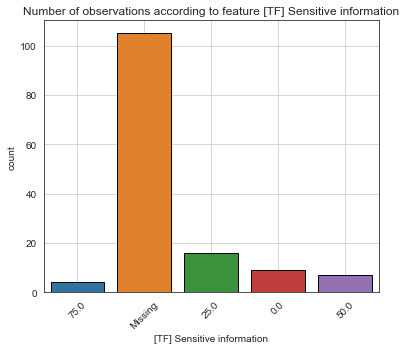

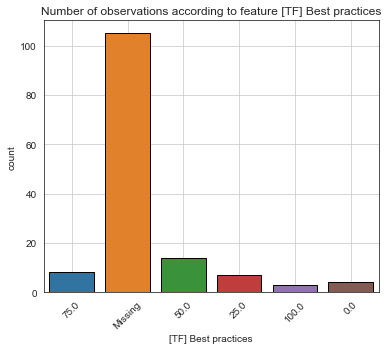

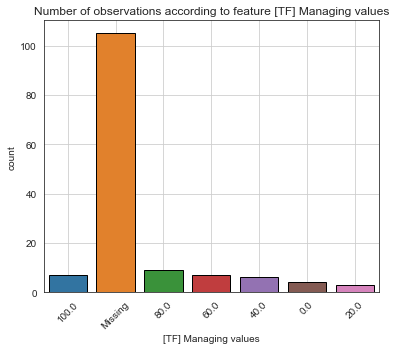

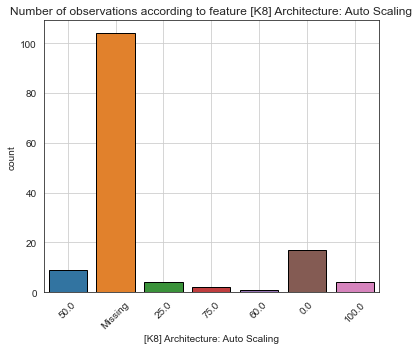

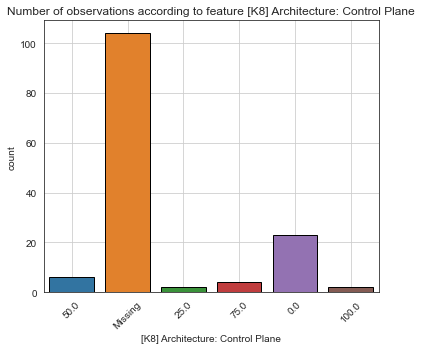

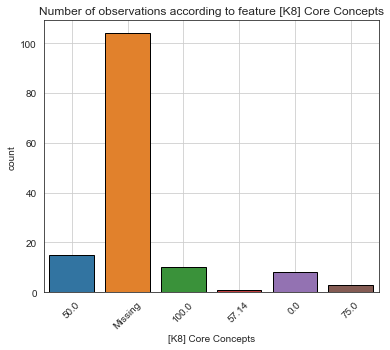

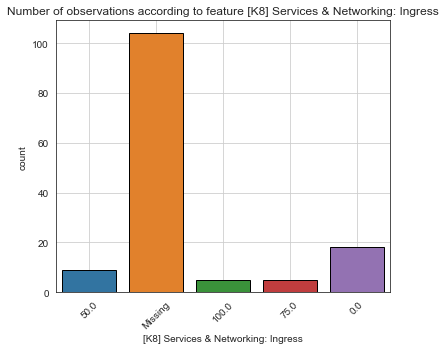

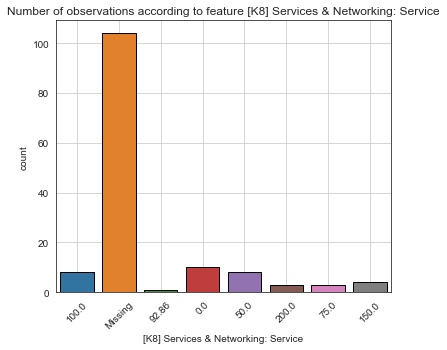

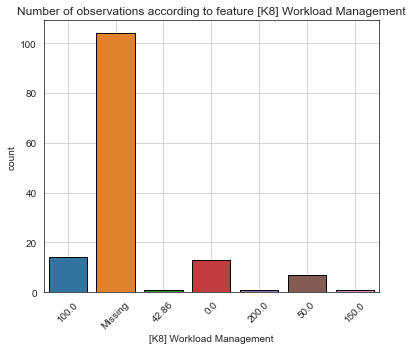

In [21]:
for i in range (0, df.shape[1]):
    generate_barplot (df, df.columns[i] )

### Generate boxplots

/var/folders/gd/xh4p1yxj22l01dr06998m3hw0000gp/T/ipykernel_76422/2045861405.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["{0}_scaled".format(feature)] = scale(new_df[feature], with_mean=True, with_std=True)


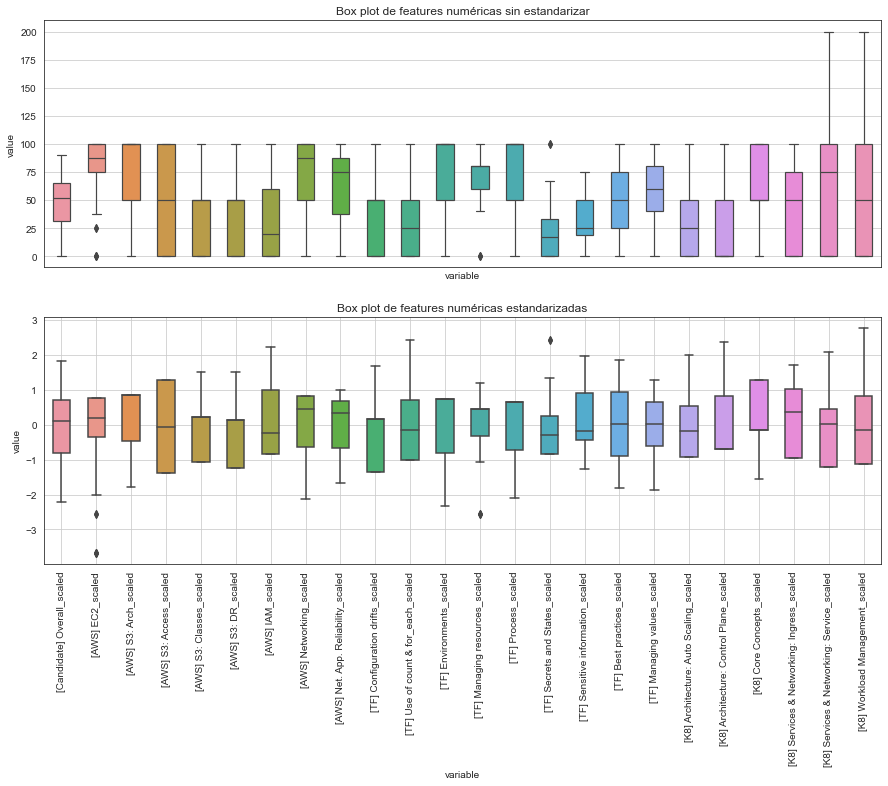

In [22]:
generate_boxplots (df)

### Generate missings

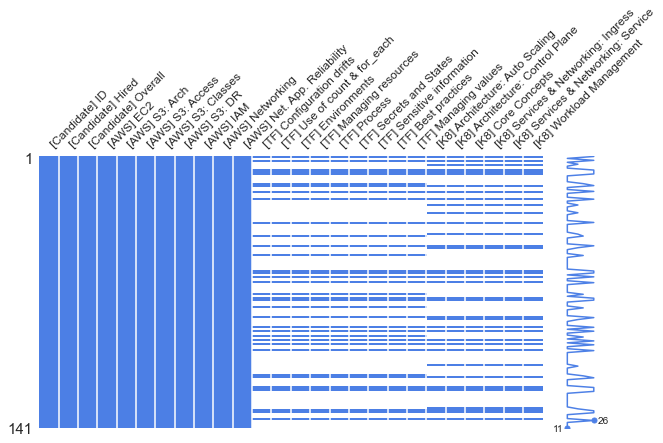

In [23]:
generate_missings (df)

### Generate correlation analysis

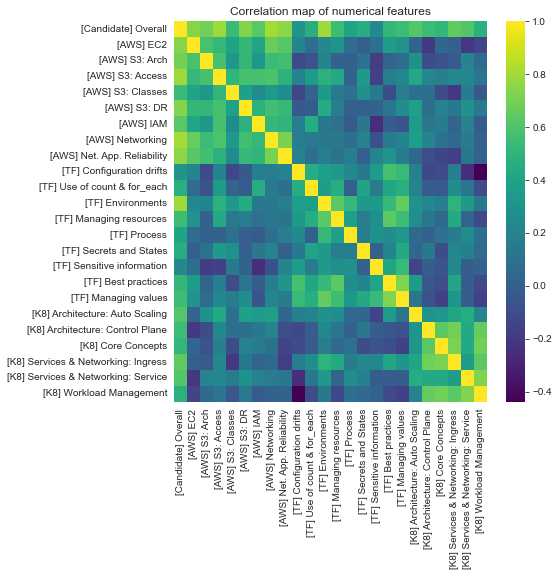

In [24]:
generate_correlation_analysis (df)

### Generate interactions

No handles with labels found to put in legend.


<Figure size 1440x1440 with 0 Axes>

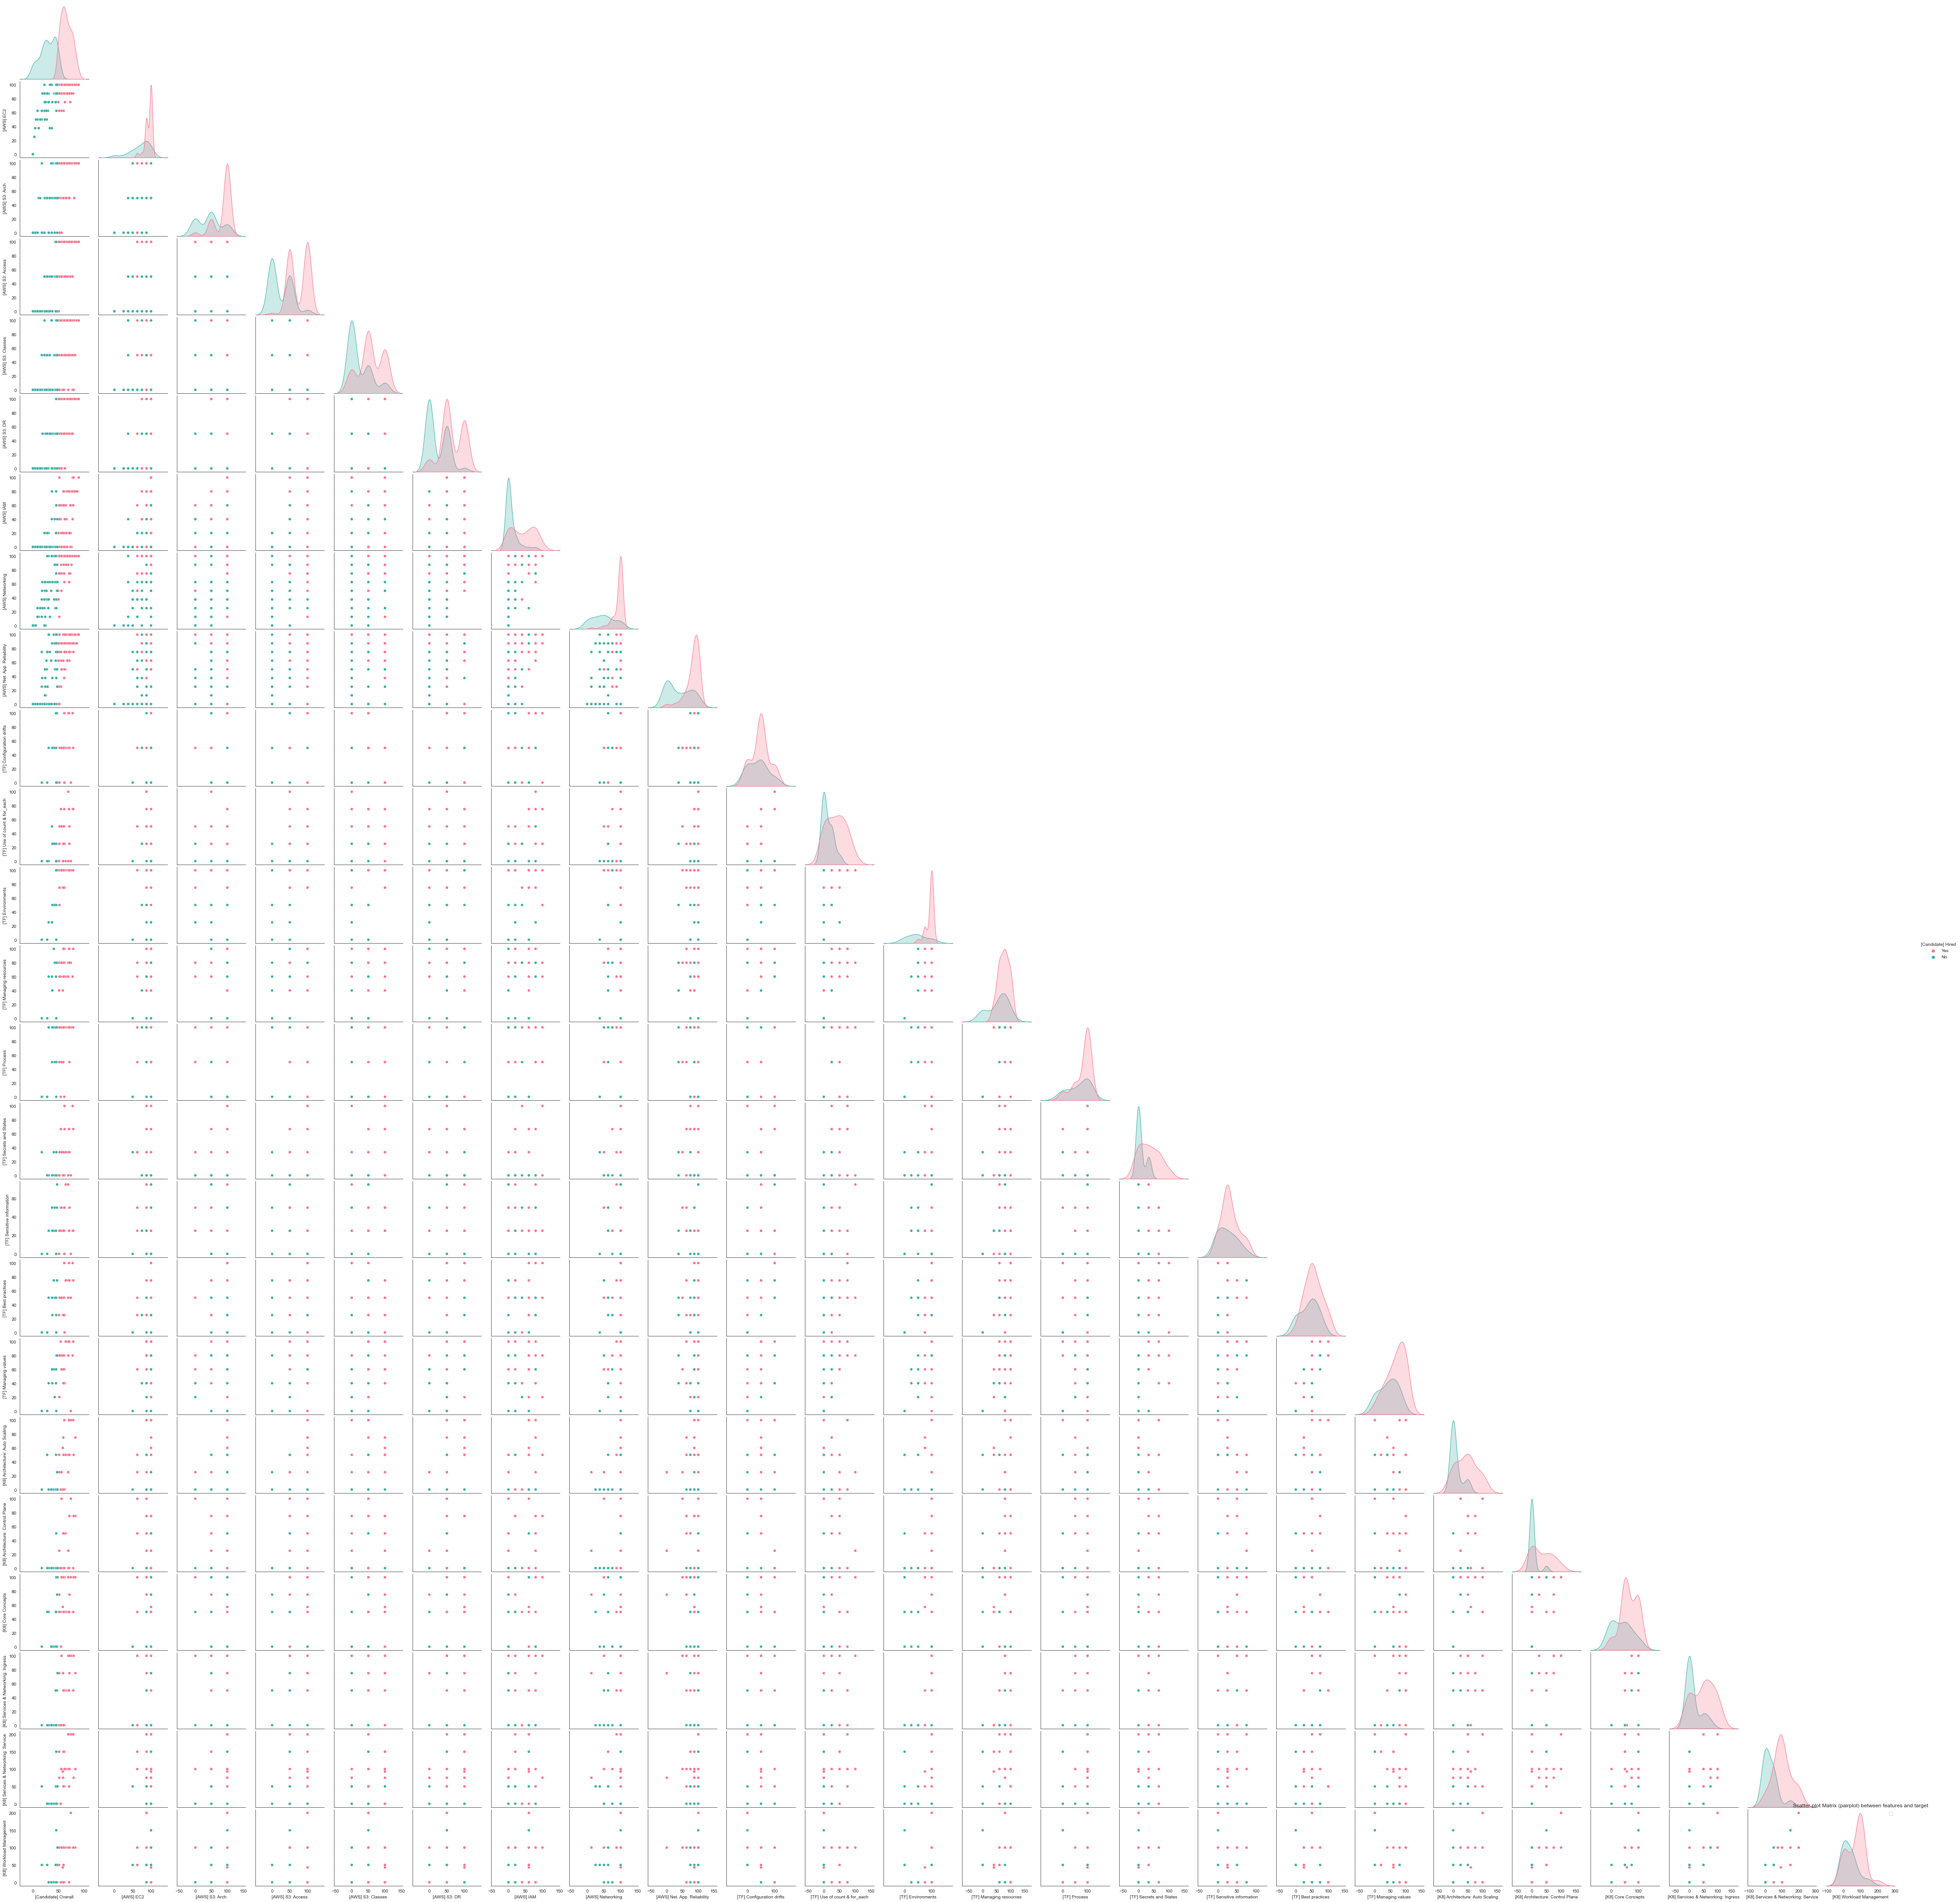

In [25]:
generate_interactions (df, df.columns[1])

# Export

## Dataset

In [1]:
saving_path = '../../data'
df.to_csv( os.path.join(saving_path, 'dataset.csv') ,sep = ',', index = False)

NameError: name 'df' is not defined